# HW1 Additional Problem

In homework 1, you applied the techniques discussed in lecture to perform correspondance based 3d reconstruction. Using Singular Value Decomposition (SVD) along with provided 2d/3d corrsepondance labels, you were able to determine projection matrices and a point cloud reconstruction of a provided set of images.

In this problem, you will extend on the techniques shown in lecture to demonstrate the tradeoffs of other approaches to the same problem. Additionally, you will learn to use an existing state of the art correpondance network (Dust3r/Mast3r) in order to learn how researchers currently attempt this problem!

# Initial setup
Copy & paste your `calculate_reprojection_error` and `calculate_projection` functions into the cell below. Additionally, copy and paste your code for calculating the design matrix $A$ into the function `create_design_matrix` into the provided function stub below (note: this is just the code you used in `calculate_projection_matrix` to compute the A matrix). It is reccomended to modify your `calculate_projetion` function to get $A$ from the `create_design_matrix` function result instead of calculating it in the main function body.

Additionally, make sure to run the cell provided that downloads the HW1 data from drive

In [ ]:
# Download the HW1 data and unzip
!wget "https://drive.google.com/uc?export=download&id=1rmAt35Gu9VC8xp9dDTHiCRhaailVAJWD" -O HW1.zip
!unzip HW1.zip
!unzip HW1/src/data.zip
!rm HW1.zip
!rm -rf HW1
!rm -rf __MACOSX/

--2025-02-03 14:54:19--  https://drive.google.com/uc?export=download&id=1rmAt35Gu9VC8xp9dDTHiCRhaailVAJWD
Resolving drive.google.com (drive.google.com)... 172.217.194.139, 172.217.194.102, 172.217.194.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1rmAt35Gu9VC8xp9dDTHiCRhaailVAJWD&export=download [following]
--2025-02-03 14:54:19--  https://drive.usercontent.google.com/download?id=1rmAt35Gu9VC8xp9dDTHiCRhaailVAJWD&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.118.132, 2404:6800:4003:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.118.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5002799 (4.8M) [application/octet-stream]
Saving to: ‘HW1.zip’

HW1.zip             100%[===================>]   4.77M  15.0MB/s 

In [44]:
import cv2
import os
import sys
import numpy as np
import time
import scipy

def create_design_matrix(pts2d, pts3d):
    """
    Compute the 12x2N design matrix M using a set of N 2D-3D point correspondences.

    This is the same matrix you used in homework 1 to run SVD on and is equivalent
    to the A matrix in the least squares equations.

    Parameters:
    pts2d (numpy.ndarray): An Nx2 array containing the 2D image points.
    pts3d (numpy.ndarray): An Nx3 array containing the corresponding 3D world coordinates.

    Returns:
    A (numpy.ndarray): A 12x(2N) design matrix for the projection matrix least-squares problem
    """
    N = pts2d.shape[0]
    A = []
    for i in range(N):
        # Get the 3D world coordinates and 2D image coordinates for the i-th point
        X, Y, Z = pts3d[i, :]
        x, y = pts2d[i, :]
        # Append the row to the A matrix
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -x * X, -x * Y, -x * Z, -x])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -y * X, -y * Y, -y * Z, -y])
    A = np.array(A)

    return A

def calculate_projection(pts2d, pts3d):
    """
    Compute a 3x4 projection matrix M using a set of 2D-3D point correspondences.

    Given a set of N 2D image points (pts2d) and their corresponding 3D world coordinates
    (pts3d), this function calculates the projection matrix M using the Direct Linear
    Transform (DLT) method. The projection matrix M relates the 3D world coordinates to
    their 2D image projections in homogeneous coordinates.

    Parameters:
    pts2d (numpy.ndarray): An Nx2 array containing the 2D image points.
    pts3d (numpy.ndarray): An Nx3 array containing the corresponding 3D world coordinates.

    Returns:
    M (numpy.ndarray): A 3x4 projection matrix M that relates 3D world coordinates to 2D
                   image points in homogeneous coordinates.
    """
    A = create_design_matrix(pts2d, pts3d)
    U, S, Vt = np.linalg.svd(A)
    V = Vt[-1, :]
    M = np.reshape(V, (3, 4))
    
    M = M / np.linalg.norm(M)
    return M

def calculate_reprojection_error(pts2d, pts3d, M):
    """
    Calculate the reprojection error for a set of 2D-3D point correspondences.

    Given a set of N 2D image points (pts2d) and their corresponding 3D world coordinates
    (pts3d), this function calculates the reprojection error. The reprojection error is a
    measure of how accurately the 3D points project onto the 2D image plane when using a
    projection matrix.

    Parameters:
    pts2d (numpy.ndarray): An Nx2 array containing the 2D image points.
    pts3d (numpy.ndarray): An Nx3 array containing the corresponding 3D world coordinates.

    Returns:
    float: The reprojection error, which quantifies the accuracy of the 3D points'
           projection onto the 2D image plane.
    """

    # Project the 3D points onto the image plane using the projection matrix
    pts3d_h = np.hstack([np.array(pts3d), np.ones((len(pts3d), 1))])

    # Project the 3D points onto the image plane using the projection matrix
    pts3d_projected = pts3d_h @ M.T

    # Normalize the projected 3D points to obtain the 2D image coordinates
    x_ = pts3d_projected[:, 0] / pts3d_projected[:, 2]
    y_ = pts3d_projected[:, 1] / pts3d_projected[:, 2]

    # Calculate the reprojection error for each 3D point
    diff = pts2d - np.column_stack([x_, y_])
    errors = np.linalg.norm(diff, axis=1)

    return errors.mean()


# Other Approaches to Solving least squares problems

Assuming we have an problem like in Homework 1 in the form $Ax = b$, there are many other closed form solutions to solving the least-squares solution for $x$! We will write three versions in this assignment and characterize their outputs:


1.   Moore-Penrose Pseudoinverse
2.   QR Decomposition
3.   LU Decomposition

## Moore-Penrose Pseudoinverse

[The Moore-Penrose Pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) is a fundamental approach to finding a vector $x$ of minimum norm that solves least-squares problems $Ax=b$. It is commonly derived via [Projection Theorem](https://en.wikipedia.org/wiki/Hilbert_projection_theorem) (and note: if you have taken ROB501 you will almost certainly have had to do so already!), but a quick geometric derivation is as follows:


**Theorem 1:**Every linear system $Ax=b$ where $A$ is a matrix of size $[m,n]$ has a unique least-squares solution $x^{+}$ of smallest norm.
1. Interpret $b$ as a point in Euclidean space of proper dimensionality (e.g. $b \in \mathbb{R}^m$) - this means that the column space of $A$ is a subspace $U$ of $\mathbb{R}^m$
2. If we have a subspace $U ⊂ V$ (for any $U$ or $V$), we can reform $V$ as the union of $U$ and its orthogonal subspace $U^{\perp}$
$$V = U \oplus U^{\perp}$$
Less formally, this means that we can form any member $v$ of space $V$ as the combination of a member $u$ of subspace $U$ and $v$'s orthogonal projection onto $U$.
3. Relating back to our problem, this means that $x$ minimizes $\lVert Ax-b \rVert_{2}$ iff $b-Ax$ is orthogonal to every column of $A$.
4. This is equivalent to saying that $A^{T}(b-Ax)=0$. Rearranging this equation gets us our solution to the least-squares problem, dubbed the **Moore-Penrose Pseudoinverse**:

$$x^{+} = (A^{T}A)^{-1}A^{T}b$$


###Problem 7.1
Just as before in HW1, you will be writing a function `calculate_projection_pseudoinverse` to solve for the projection matrix given a set of 2d/3d correspondances. You should use the same design matrix $A$ as in the SVD solution here, as well as your code for calculating the reprojection error.

In [53]:
def calculate_projection_pseudoinverse(pts2d, pts3d):
    """
    Compute a 3x4 projection matrix M using a set of 2D-3D point correspondences.

    Given a set of N 2D image points (pts2d) and their corresponding 3D world coordinates
    (pts3d), this function calculates the projection matrix M using the Moore-Penrose pseudo inverse

    Parameters:
    pts2d (numpy.ndarray): An Nx2 array containing the 2D image points.
    pts3d (numpy.ndarray): An Nx3 array containing the corresponding 3D world coordinates.

    Returns:
    M (numpy.ndarray): A 3x4 projection matrix M that relates 3D world coordinates to 2D
                   image points in homogeneous coordinates.
    """
    A = create_design_matrix(pts2d, pts3d)
    b = -A[:,-1]
    A_new = A[:,:-1]
    pseudoinv = np.linalg.inv(A_new.T @ A_new) @ A_new.T
        
    x_new = pseudoinv @ b
    
    M = np.append(x_new, 1)
    M = M.reshape(3,4)
    return M


## QR Decomposition

[QR Decomposition](https://en.wikipedia.org/wiki/QR_decomposition) is another way of solving for least squares solutions. In QR decomposition, we decompose a matrix $A$ into two matrices $Q$ and $R$, where $Q$ is an orthonormal matrix (e.g. has a mmagnitude of 1 and each column is orthogonal to each other) and $R$ is an upper triangular matrix. We can compute $Q$ via several methods, such as the [Gram-Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process), and because R is upper triangular, it can be easily computed via [substitution algorithms](https://en.wikipedia.org/wiki/Triangular_matrix#Forward_and_back_substitution). For the purposes of this assignment, you may use the implementation of QR decomposition [provided by numpy](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html).

The advantage of QR decomposition is that we do not need to solve $(A^TA)^{-1}$ directly! Matrix inversions are quite expensive, so if we can avoid them that is preferrable. We can show that QR solves the least squares problem by starting from the pseudoinverse as follows:


**Theorem 2:**The solutions to the least squares system $\lVert Ax-b \rVert_{2}$ derived from QR Decomposition and the Moore-Penrose Pseudoinverse are equivalent.
1. Starting from the pseudoinverse equations, we have our least squares solution:

$$x^{+} = (A^{T}A)^{-1}A^{T}b$$

2. Performing QR decomposition on $A$ and substituting yields the following:

$$x^{+} = ((QR)^{T}QR)^{-1}(QR)^{T}b = (R^TQ^TQR)^{-1}Q^TR^Tb$$

3. Because Q is orthonormal, $Q^TQ=I$, which gives us:
$$x^{+} = (R^TR)^{-1}R^TQ^Tb = R^{-1}(R^T)^{-1}R^TQ^Tb$$
4. Cancelling terms, we then obtain
$$ x^{+} = R^{-1}Q^Tb $$

Although we still see $R^{-1}$ in this equation, we can solve this via backward substitution because $R$ is upper triangular! If $R$ is of shape `[m,n]` this then becomes of complexity $O((m*n)/2)$ as opposed to the $O((m*n)^3)$ of matrix inversion! Pseudocode for performing back substitution is as follows:


```
# given the QR decomposition of A
# where Q is an [m,n] orthogonal matrix
# R is an [n,n] upper triangular matrix
# and b is from our Ax=b least squares equation

def backsubstitution(Q, R, b):
  qt_b = matmul(transpose(Q), b)
  M = zeros(n)
  for i in [m, 0]:
    M[i] = qt_b[i] - dot( R[i][i+1:n], M[i+1:m]) / R[i,i]

  return M
```

###Problem 7.2
As before in HW1, you will be writing a function `calculate_projection_QR` to solve for the projection matrix given a set of 2d/3d correspondances. You should use the same design matrix $A$ as before, but find the solution via QR decomposition and back substitution (do not just invert R or use the numpy solver!).

In [54]:
def calculate_projection_QR(pts2d, pts3d):
    """
    Compute a 3x4 projection matrix M using a set of 2D-3D point correspondences.

    Given a set of N 2D image points (pts2d) and their corresponding 3D world coordinates
    (pts3d), this function calculates the projection matrix M using QR

    Parameters:
    pts2d (numpy.ndarray): An Nx2 array containing the 2D image points.
    pts3d (numpy.ndarray): An Nx3 array containing the corresponding 3D world coordinates.

    Returns:
    M (numpy.ndarray): A 3x4 projection matrix M that relates 3D world coordinates to 2D
                   image points in homogeneous coordinates.
    """

    A = create_design_matrix(pts2d, pts3d)
    b = -A[:,-1]
    A_new = A[:,:-1]
    
    q, r = np.linalg.qr(A_new)
    qt_b = q.T @ b
    print(qt_b.shape)
    print(r.shape)
    
    m, n= r.shape
    M = np.zeros(n)
    for i in range(m-1, -1, -1):
        M[i] = (qt_b[i] - np.dot(r[i][i+1:n], M[i+1:m]))/r[i,i]
    
    M = np.append(M, 1)
    M = M / np.linalg.norm(M)
    M = M.reshape(3,4)
        
    return M


## LU Decomposition

[LU Decomposition](https://en.wikipedia.org/wiki/LU_decomposition) is another way of solving for least squares solutions, although it is typically targeted at solving exact equations (instead of norm minimization). In LU decomposition, we decompose a matrix $A$ into two matrices $L$ and $U$, where $L$ is a lower triangular matrix and $U$ is an upper triangular matrix. For the purposes of this assignment, you may use the implementation of LU decomposition [provided by scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html).

Like QR decomposition, we are trying to avoid computing $(A^TA)^{-1}$ directly. Unlike QR decomposition however, we solve this directly using both forward and backwards substitution, leveraging the triangular nature of the matrices. The derivation steps for the LU least squares solution are below


**Theorem 3:**The solutions to the least squares system $\lVert Ax-b \rVert_{2}$ can be derived via LU substitution starting at the pseudo inverse.

1. Starting from the pseudoinverse equations, we have our least squares solution:

$$x = (A^{T}A)^{-1}A^{T}b$$

in normal equation form:
$$A^TAx = A^Tb$$

2. We then perform LU decomposition on $A^TA$.

$$LUx = A^Tb$$

3. We then use an intermediate variable $y$ and solve for it via forward substitution

$$Ly = A^Tb$$

4. Finally, we obtain $x$ using the same backward substitution technique in QR decomposition from the following equation.

$$Ux = y$$

Like QR decomposition, we leverage subsitution methods here to avoid directly computing inverses. Pseudocode for forward substitution is shown below, and is very similar to the backwards substitution code from before. You will need to adapt your backwards substitution code as well to take in the `U` and `y` instead of `Q`, `R`, and `b` (or you can generalize your backward substitution code into a single function for both methods).


```
# given the L component of the LR decomposition of A
# and b which is from our Ax=b least squares equation
# where L is of shape [n,n]
# and b is of shape [n]

def forward_substituion(L, b):
  y = zeros(n)

  for i in [0, n]:
    y[i] = b[i] - dot(L[i][0:i], y[0:i])

  return y
```

###Problem 7.3
Write a function `calculate_projection_LU` to solve for the projection matrix given a set of 2d/3d correspondances. You should use the same design matrix $A$ as before, but find the solution via LU decomposition and forward/back substitution (do not just invert the matrices or use the numpy solver!).

In [55]:
def forward_substitution(L, b):
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        y[i] = (b[i] - np.dot(L[i, :i], y[:i])) / L[i, i]
    return y

def backward_substitution(U, y):
    n = len(y)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1): 
        x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    return x

def calculate_projection_LU(pts2d, pts3d):
    """
    Compute a 3x4 projection matrix M using a set of 2D-3D point correspondences.

    Given a set of N 2D image points (pts2d) and their corresponding 3D world coordinates
    (pts3d), this function calculates the projection matrix M using LU decomposition

    Parameters:
    pts2d (numpy.ndarray): An Nx2 array containing the 2D image points.
    pts3d (numpy.ndarray): An Nx3 array containing the corresponding 3D world coordinates.

    Returns:
    M (numpy.ndarray): A 3x4 projection matrix M that relates 3D world coordinates to 2D
                   image points in homogeneous coordinates.
    """
    A = create_design_matrix(pts2d, pts3d)
    b = -A[:,-1]
    A_new = A[:,:-1]
    
    P, L, U = scipy.linalg.lu(A_new.T @ A_new)
    at_b = P @ (A_new.T @ b)
    
    y = forward_substitution(L, at_b)
    x = backward_substitution(U, y)
    
    M = np.append(x, 1)
    M = M / np.linalg.norm(M)
    M = M.reshape(3,4)
    
    return M

###Problem 7.4

We will now compare the execution time and reprojection errrors of these new methods on our original projection matrix problem. Examine the results, and provide some analysis discussing what the results are and why that may be the case.

In [57]:
data = np.load("/data/camera_calib_data.npz")
pts2d = data['pts2d']
pts3d = data['pts3d']

qr_start = time.perf_counter_ns()
P_qr = calculate_projection_QR(pts2d,pts3d)
qr_end = time.perf_counter_ns()
print(f"qr_start: {qr_start}, qr_end: {qr_end}")

svd_start = time.perf_counter_ns()
P = calculate_projection(pts2d,pts3d)
svd_end = time.perf_counter_ns()
print(f"svd_start: {svd_start}, svd_end: {svd_end}")

pinv_start = time.perf_counter_ns()
P_pinv = calculate_projection_pseudoinverse(pts2d, pts3d)
pinv_end = time.perf_counter_ns()
print(f"pinv_start: {pinv_start}, pinv_end: {pinv_end}")

LU_start = time.perf_counter_ns()
P_LU = calculate_projection_LU(pts2d, pts3d)
LU_end = time.perf_counter_ns()
print(f"LU_start: {pinv_start}, LU_end: {pinv_end}")

reprojection_error = calculate_reprojection_error(pts2d, pts3d, P)
reprojection_error_qr = calculate_reprojection_error(pts2d, pts3d, P_qr)
reprojection_error_pinv = calculate_reprojection_error(pts2d, pts3d, P_pinv)
reprojection_error_lu = calculate_reprojection_error(pts2d, pts3d, P_LU)

print()
print(f"Projection matrix SVD: {P}")
print(f"Projection matrix QR: {P_qr}")
print(f"Projection matrix Pseudo-inverse: {P_pinv}")
print(f"Projection matrix LU: {P_LU}")
print()
print(f"Reprojection Error SVD: {reprojection_error}")
print(f"Reprojection Error QR: {reprojection_error_qr}")
print(f"Reprojection Error Pseudo-inverse: {reprojection_error_pinv}")
print(f"Reprojection Error LU: {reprojection_error_lu}")
print(f"SVD time: {svd_end - svd_start}")
print(f"QR time: {qr_end - qr_start}")
print(f"Pseudo-inverse time: {pinv_end - pinv_start}")
print(f"LU time: {LU_end - LU_start}")

(11,)
(11, 11)
qr_start: 814520958209125, qr_end: 814520975364208
svd_start: 814520975430833, svd_end: 814520979019500
pinv_start: 814520979054916, pinv_end: 814520988318833
LU_start: 814520979054916, LU_end: 814520988318833

Projection matrix SVD: [[ 0.45827554 -0.29474237 -0.01395746  0.0040258 ]
 [-0.05085589 -0.0545847  -0.54105993 -0.05237592]
 [ 0.10900958  0.17834548 -0.04426782  0.5968205 ]]
Projection matrix QR: [[ 0.45828095 -0.29474332 -0.01396452  0.00402529]
 [-0.05085792 -0.05459096 -0.54104038 -0.05237589]
 [ 0.10901111  0.17835024 -0.04428027  0.59683007]]
Projection matrix Pseudo-inverse: [[ 0.76785834 -0.49384797 -0.02339781  0.00674445]
 [-0.0852134  -0.09146818 -0.90652332 -0.08775678]
 [ 0.18265016  0.29882917 -0.07419242  1.        ]]
Projection matrix LU: [[ 0.45828095 -0.29474332 -0.01396452  0.00402529]
 [-0.05085792 -0.05459096 -0.54104038 -0.05237589]
 [ 0.10901111  0.17835024 -0.04428027  0.59683007]]

Reprojection Error SVD: 0.002227447088278742
Reprojectio

# Put your results discussion here
Computational Speed:
SVD is the fastest (3.8 ms) among decomposition-based methods, likely due to NumPy’s LAPACK optimizations.
QR is slower than SVD (6.5 ms), which aligns with its higher computational complexity.
LU is faster than QR (~8.4 ms vs. 6.5 ms), making it a good alternative where QR is traditionally used.
The pseudo-inverse approach is significantly slower (~29.1 ms), nearly 4× slower than LU and 8× slower than SVD.

Reprojection Error:
SVD, QR, and LU yield nearly identical reprojection errors (~0.002227), confirming their accuracy. The error of the pseudo-inverse method is slightly lower than that of SVD, QR, and LU, but only within a very small range of values.

LU decomposition is an effective and computationally efficient alternative to QR decomposition for solving least squares problems. While SVD offers the highest numerical stability, LU decomposition strikes a balance between accuracy and speed, making it a strong candidate for real-time applications. However, explicitly computing the pseudoinverse using matrix inversion is computationally expensive and should generally be avoided.

I would choose LU because it offers a viable alternative to QR and is more computationally efficient than QR.

# Connection to research - Foundational CV Models

For the final part of this problem, we will be analyzing the results of these methods on the output of [Mast3r](https://arxiv.org/abs/2406.09756). Mast3r is based on some previous works - namely [Dust3r](https://openaccess.thecvf.com/content/CVPR2024/html/Wang_DUSt3R_Geometric_3D_Vision_Made_Easy_CVPR_2024_paper.html) and [CroCo](https://proceedings.neurips.cc/paper_files/paper/2022/hash/16e71d1a24b98a02c17b1be1f634f979-Abstract-Conference.html).

Mast3r is a model trained to perform 3d reconstruction without a-priori intrinsic or extrinsic knowledge. As a part of that process, it additionally outputs inferred correspondances, which we will be using to compare against the sparse ones we had in the main part of HW1.

It is not required that you read these papers to complete this assignment, but it is highly recomended in general! These can also likely help provide inspiration or a launching point for your class project.

### Setup cells

You dont need to edit any of these (just run them) but they are provided for you to inspect if you wish to use a similar model as part of your project.

**Initial Setup of dependencies**

Should only need to be run once per runtime (make sure to be on a GPU instance). Note that this may take some time as the packages and model weights are not small.

In [ ]:
!rm -rf mast3r
!git clone --recursive https://github.com/naver/mast3r
%cd mast3r
!pip install -r requirements.txt
!pip install -r dust3r/requirements.txt
!pip install -r dust3r/requirements_optional.txt
%cd dust3r/croco/models/curope/
!python setup.py build_ext --inplace
%cd ../../../../

Cloning into 'mast3r'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 232 (delta 113), reused 99 (delta 99), pack-reused 87 (from 2)
Receiving objects: 100% (232/232), 3.58 MiB | 29.83 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Submodule 'dust3r' (https://github.com/naver/dust3r) registered for path 'dust3r'
Cloning into '/content/mast3r/dust3r'...
remote: Enumerating objects: 550, done.        
remote: Counting objects: 100% (403/403), done.        
remote: Compressing objects: 100% (208/208), done.        
remote: Total 550 (delta 291), reused 195 (delta 195), pack-reused 147 (from 1)        
Receiving objects: 100% (550/550), 733.06 KiB | 2.89 MiB/s, done.
Resolving deltas: 100% (318/318), done.
Submodule path 'dust3r': checked out '9869e71f9165aa53c53ec0979cea1122a569ade4'
Submodule 'croco' (https://github.com/naver/croco) registered for path 'dust3r/croco'
Cloning in

In [ ]:
%mkdir -p checkpoints/
!wget https://download.europe.naverlabs.com/ComputerVision/MASt3R/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth -P checkpoints/

--2025-02-03 15:00:27--  https://download.europe.naverlabs.com/ComputerVision/MASt3R/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
Resolving download.europe.naverlabs.com (download.europe.naverlabs.com)... 110.234.56.25
Connecting to download.europe.naverlabs.com (download.europe.naverlabs.com)|110.234.56.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2754910614 (2.6G)
Saving to: ‘checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth’

MASt3R_ViTLarge_Bas 100%[===================>]   2.57G  22.4MB/s    in 1m 58s  

2025-02-03 15:02:26 (22.3 MB/s) - ‘checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth’ saved [2754910614/2754910614]


In [ ]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs
import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

In [ ]:
device = 'cuda'
schedule = 'cosine'
lr = 0.01
niter = 300
model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.75G [00:00<?, ?B/s]

In [ ]:
%cd content/mast3r

[Errno 2] No such file or directory: 'content/mast3r'
/content/mast3r


## Load our images and display correspondances
Run the Mast3r Model on our images from hw1 and display some of the discovered correspondances

In [ ]:
# images = load_images(['dust3r/croco/assets/Chateau1.png', 'dust3r/croco/assets/Chateau2.png'], size=512)
images = load_images(['../data/im1.png', '../data/im2.png'], size=512)
output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

>> Loading a list of 2 images
 - adding ../data/im1.png with resolution 480x640 --> 384x512
 - adding ../data/im2.png with resolution 480x640 --> 384x512
 (Found 2 images)


/content/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/content/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/content/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [ ]:
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']
desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

matches_im0, matches_im1 = fast_reciprocal_NNs(\
    desc1, desc2, subsample_or_initxy1=1,\
    device=device, dist='dot', block_size=2**13)

# ignore small border around the edge
H0, W0 = view1['true_shape'][0]
valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) \
  & (matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

H1, W1 = view2['true_shape'][0]
valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) \
  & (matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

valid_matches = valid_matches_im0 & valid_matches_im1

matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

In [ ]:
matches_im0.shape

(72360, 2)

In [ ]:
print(f"H0: {H0}, W0:{W0}")

H0: 512, W0:384


In [ ]:
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl

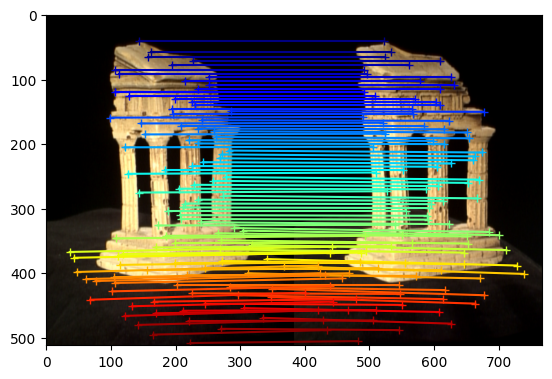

In [ ]:
n_viz = 100
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

viz_imgs = []
for i, view in enumerate([view1, view2]):
    rgb_tensor = view['img'] * image_std + image_mean
    viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img = np.concatenate((img0, img1), axis=1)
pl.figure()
pl.imshow(img)
cmap = pl.get_cmap('jet')
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
pl.show(block=True)

# Deeper examination of other solution approaches
Mast3r gives us an estimate of 2d/2d correspondances and their associated 3d points in each camera frame. We've already written the code to call the model on the Temple image used in the main HW1, and we've provided 2d and 3d points below. Your job is going to be to collect data on the runtime, condition number (of the design matrix), and reprojection error for the SVD, QR, Pseudoinverse, and LU methods of obtaining the projection matrix. The [condition number](https://en.wikipedia.org/wiki/Condition_number) is a useful metric for telling us how 'well behaved' a matrix is for solving these kinds of equations. Heuristically speaking, it tells us how sensitive the output is in relation to small changes of the inputs. Well conditioned $A$ matrices have low condition numbers, and tend to be numerically more stable, where as pooly conditioned matrices tend to have the opposite characteristics.

Your task is to do the following:

1.   Select 10 different quantities of correspondances to sample (note: there must be sufficient number of correspondances to obtain a solution, but not so many that repeated trials/samples dont degenerate into the entire set of correspondances).
2.   For each chosen quantity N, randomly select those N correspondances from the total set of correspondances (without replacement), and determine the runtime, condition number (as determined by [np.linalg.cond](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cond.html) of the $A$ matrix), and reprojection error of the four methods discussed earlier. Refer to the earlier cells to show the perferred way of measuring function runtime in python.
3. Generate figures describing the important relationships for the relevant metrics for each method. How does each method trade off condition vs. accuracy? How does each method scale with respect to number of correspondances? Generate whatever figures you most prefer, but provide provide textual analysis describing your results. In general, describe how each method performed and how your results might influence your choice of solver going forward.



In [ ]:
# contains the image x,y and camera space x,y,z points of the valid correspondances
matches_im0_3d = pred1['pts3d'][0, matches_im0[:,1], matches_im0[:,0]]

results = {
    'sample_size': [],
    'condition number': [],
    'error': [],
    'SVD': {'time': [], 'error': []},
    'QR': {'time': [], 'error': []},
    'PseudoInv': {'time': [], 'error': []},
    'LU': {'time': [], 'error': []},
}

N = [6, 18, 50, 100, 300] #numbers of point for samping

for n in N:
  idx = np.random.choice(matches_im0.shape[0], n, replace=False)
  pts2d = matches_im0[idx]       
  pts3d = matches_im0_3d[idx] 

  A = create_design_matrix(pts2d, pts3d)
  results['sample_size'].append(n)

  cond_A = np.linalg.cond(A)
  results['condition number'].append(cond_A)

  qr_start = time.perf_counter_ns()
  P_qr = calculate_projection_QR(pts2d,pts3d)
  qr_end = time.perf_counter_ns()
  time_qr = qr_end - qr_start
  results['QR']['time'].append(time_qr)

  svd_start = time.perf_counter_ns()
  P = calculate_projection(pts2d,pts3d)
  svd_end = time.perf_counter_ns()
  time_svd = svd_end - svd_start
  results['SVD']['time'].append(time_svd)

  pinv_start = time.perf_counter_ns()
  P_pinv = calculate_projection_pseudoinverse(pts2d, pts3d)
  pinv_end = time.perf_counter_ns()
  time_pinv = pinv_end - pinv_start
  results['PseudoInv']['time'].append(time_pinv)

  LU_start = time.perf_counter_ns()
  P_LU = calculate_projection_LU(pts2d, pts3d)
  LU_end = time.perf_counter_ns()
  time_LU = LU_end - LU_start
  results['LU']['time'].append(time_LU)

  reprojection_error = calculate_reprojection_error(pts2d, pts3d, P)
  results['SVD']['error'].append(reprojection_error)
  reprojection_error_qr = calculate_reprojection_error(pts2d, pts3d, P_qr)
  results['QR']['error'].append(reprojection_error_qr)
  reprojection_error_pinv = calculate_reprojection_error(pts2d, pts3d, P_pinv)
  results['PseudoInv']['error'].append(reprojection_error_pinv)
  reprojection_error_lu = calculate_reprojection_error(pts2d, pts3d, P_LU)
  results['LU']['error'].append(reprojection_error_lu)


pl.figure(figsize=(12, 4))

pl.subplot(1, 4, 1)
pl.plot(results['sample_size'], results['SVD']['error'], label='SVD')
pl.plot(results['sample_size'], results['QR']['error'], label='QR')
pl.plot(results['sample_size'], results['PseudoInv']['error'], label='PseudoInv')
pl.plot(results['sample_size'], results['LU']['error'], label='LU')
pl.xlabel('Number of correspondences')
pl.ylabel('Reprojection Error')
pl.title('Error vs. Number of correspondences')
pl.legend()

pl.subplot(1, 4, 2)
pl.plot(results['sample_size'], results['SVD']['time'], label='SVD')
pl.plot(results['sample_size'], results['QR']['time'], label='QR')
pl.plot(results['sample_size'], results['PseudoInv']['time'], label='PseudoInv')
pl.plot(results['sample_size'], results['LU']['time'], label='LU')
pl.xlabel('Number of correspondences')
pl.ylabel('Runtime (s)')
pl.title('Runtime vs. Number of correspondences')
pl.legend()

pl.subplot(1, 4, 3)
pl.plot(results['sample_size'], results['condition number'], label='condition number')
pl.xlabel('Number of correspondences')
pl.ylabel('Condition number')
pl.title('Condition number vs. Number of correspondences')
pl.legend()

pl.subplot(1, 4, 4)
pl.plot(results['condition number'], results['SVD']['error'], label='SVD')
pl.plot(results['condition number'], results['QR']['error'], label='QR')
pl.plot(results['condition number'], results['PseudoInv']['error'], label='PseudoInv')
pl.plot(results['condition number'], results['LU']['error'], label='LU')
pl.xlabel('Condition number')
pl.ylabel('Reprojection Error')
pl.title('Error vs. Condition number')
pl.legend()


pl.show()

# Results analysis
Place your figure outputs above, and refer to them here along with your other textual analysis

# Final 3D Reconstruction

Finally, using the same 2d/3d correspondances frome above (matches_im0, matches_im1, matches_im0_3d, matches_im1_3d), compute the 3d reconstruction as before in the original HW1. Take the same 2d points in each image from HW1 and compare the original reconstruction to the new one obtained using Mast3r. How do they compare?

In [ ]:
import sys
import sparse_reconstruction as sr

data_for_intrinsics = np.load("data/intrinsics.npz")
K1 = data_for_intrinsics['K1']
K2 = data_for_intrinsics['K2']

scale = 512
pts1 = matches_im0
pts2 = matches_im1
F = sr.compute_fundamental_matrix(pts1, pts2, scale)
print("Computed Fundamental Matrix:\n", F)

E = sr.compute_essential_matrix(K1, K2, F)
print("Computed Essential Matrix:\n", E)

pts1_hom = np.hstack([pts1, np.ones((N, 1))])  # (N, 3)
pts2_hom = np.hstack([pts2, np.ones((N, 1))])  # (N, 3)

pts1_hom_T = pts1_hom.T  # (3, N)
pts2_hom_T = pts2_hom.T  # (3, N)

# normalize the points by using intrinsic matrices
pts1_normalized = np.dot(np.linalg.inv(K1), pts1_hom_T).T  # (N, 3)
pts2_normalized = np.dot(np.linalg.inv(K2), pts2_hom_T).T  # (N, 3)

# Here we need N,2 as input for triangulatePoints()
pts1_normalized = pts1_normalized[:, :2]  # (N, 2)
pts2_normalized = pts2_normalized[:, :2]  # (N, 2)

point_cloud, _ = sr.triangulate_points(E, pts1_normalized, pts2_normalized, K1, K2)




### Put your textural analysis comparing your original reconstruction to the Mast3r derived one here